In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers

import yaml

In [2]:
predictions_dict = {}

In [3]:
config_filename = 'weights.yaml'
config = read_config(config_filename)

In [4]:
config

{&#39;fitting&#39;: {&#39;data&#39;: {&#39;data_source&#39;: &#39;covid19india&#39;,
   &#39;stratified_data&#39;: False,
   &#39;dataloading_params&#39;: {&#39;state&#39;: &#39;Jharkhand&#39;,
    &#39;district&#39;: &#39;Ranchi&#39;,
    &#39;use_dataframe&#39;: &#39;data_all&#39;},
   &#39;smooth_jump&#39;: False,
   &#39;smooth_jump_params&#39;: None,
   &#39;rolling_average&#39;: True,
   &#39;rolling_average_params&#39;: {&#39;center&#39;: True,
    &#39;window_size&#39;: 7,
    &#39;win_type&#39;: None,
    &#39;min_periods&#39;: 3,
    &#39;split_after_rolling&#39;: False}},
  &#39;model&#39;: models.seir.seirhd.SEIRHD,
  &#39;variable_param_ranges&#39;: {&#39;lockdown_R0&#39;: [[0.7, 1.8], &#39;uniform&#39;],
   &#39;T_inc&#39;: [[4, 5], &#39;uniform&#39;],
   &#39;T_inf&#39;: [[3, 4], &#39;uniform&#39;],
   &#39;T_recov&#39;: [[0, 40], &#39;uniform&#39;],
   &#39;T_recov_fatal&#39;: [[0, 40], &#39;uniform&#39;],
   &#39;P_fatal&#39;: [[0, 0.1], &#39;uniform&#39;],
   &#39;E_h

In [5]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_06102020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 153                 | 154                 | 155                 | 156                 | 157                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-09-27 00:00:00 | 2020-09-28 00:00:00 | 2020-09-29 00:00:00 | 2020-09-30 00:00:00 | 2020-10-01 00:00:00 |
| state       | Jharkhand           | Jharkhand           | Jharkhand           | Jharkhand           | Jharkhand           |
| district    | Ranchi              | Ranchi              | Ranchi              | Ranchi              | Ranchi              |
| total       | 17999.43            | 18346.14            | 18512.83            | 18661.2             | 18830.25   

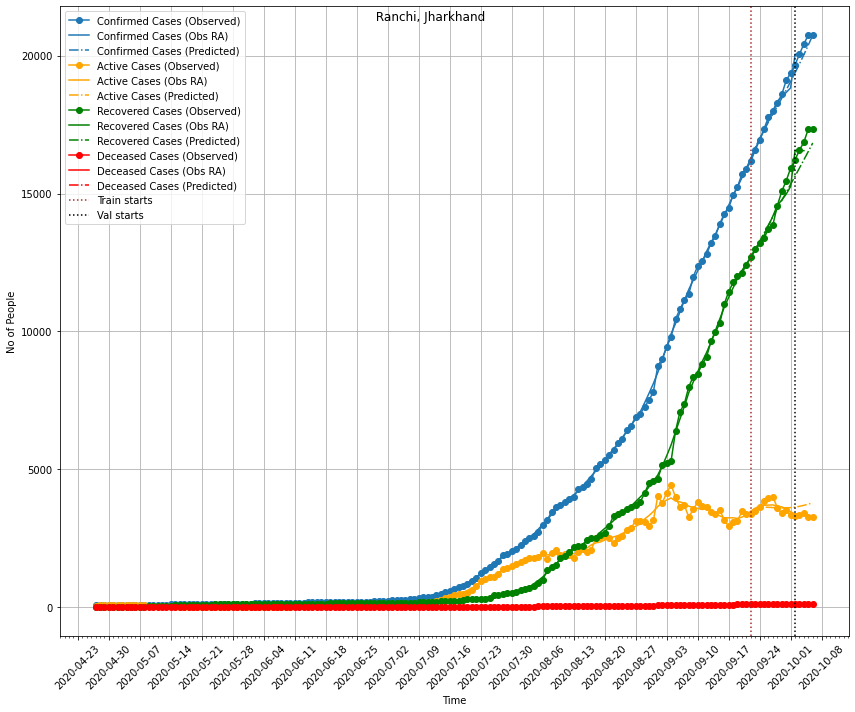

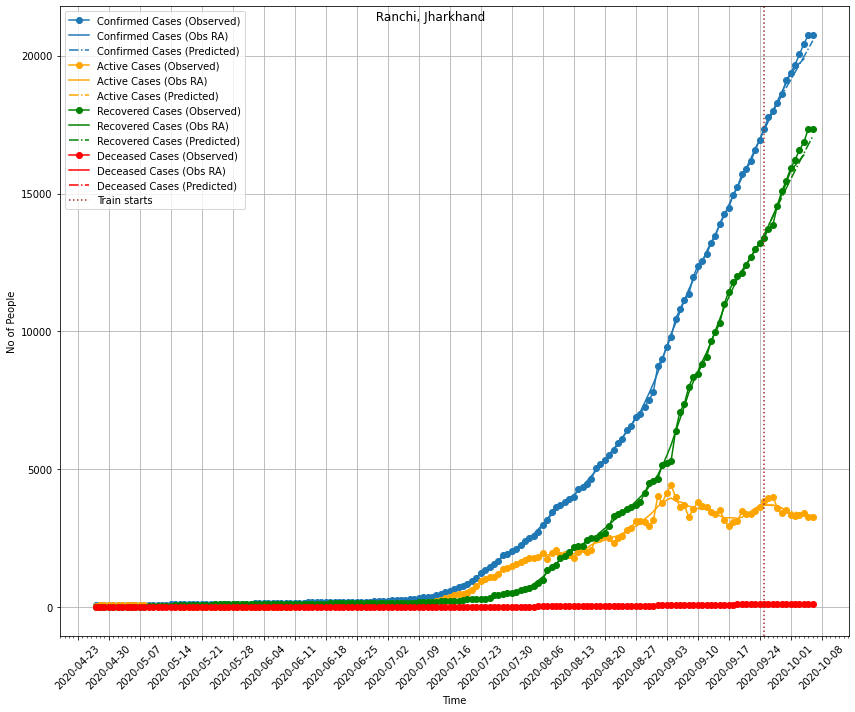

In [6]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [7]:
predictions_dict['m1']['best_params']

{&#39;E_hosp_ratio&#39;: 0.08407157540970184,
 &#39;I_hosp_ratio&#39;: 0.4680510881951535,
 &#39;P_fatal&#39;: 0.009861537063919198,
 &#39;T_inc&#39;: 4.746619148816514,
 &#39;T_inf&#39;: 3.70089349783674,
 &#39;T_recov&#39;: 12.108955966194223,
 &#39;T_recov_fatal&#39;: 35.990952698348515,
 &#39;lockdown_R0&#39;: 1.329728273643411}

In [8]:
predictions_dict['m2']['best_params']

{&#39;E_hosp_ratio&#39;: 0.20630024026716973,
 &#39;I_hosp_ratio&#39;: 0.34304066613234185,
 &#39;P_fatal&#39;: 0.01878395214345596,
 &#39;T_inc&#39;: 4.6098163247918205,
 &#39;T_inf&#39;: 3.2851815161364195,
 &#39;T_recov&#39;: 10.525504805201473,
 &#39;T_recov_fatal&#39;: 33.907003540791976,
 &#39;lockdown_R0&#39;: 1.1185255326619206}

## Loss Dataframes

### M1 Loss DataFrame

In [9]:
predictions_dict['m1']['df_loss']

train      val
total      0.803023  1.73145
active      4.64232  8.63236
recovered   1.43825  3.79658
deceased    1.59971  7.76551

### M2 Loss DataFrame

In [10]:
predictions_dict['m2']['df_loss']

train
total      0.956359
active      3.66984
recovered   1.73786
deceased    1.33154

## Sensitivity Plot

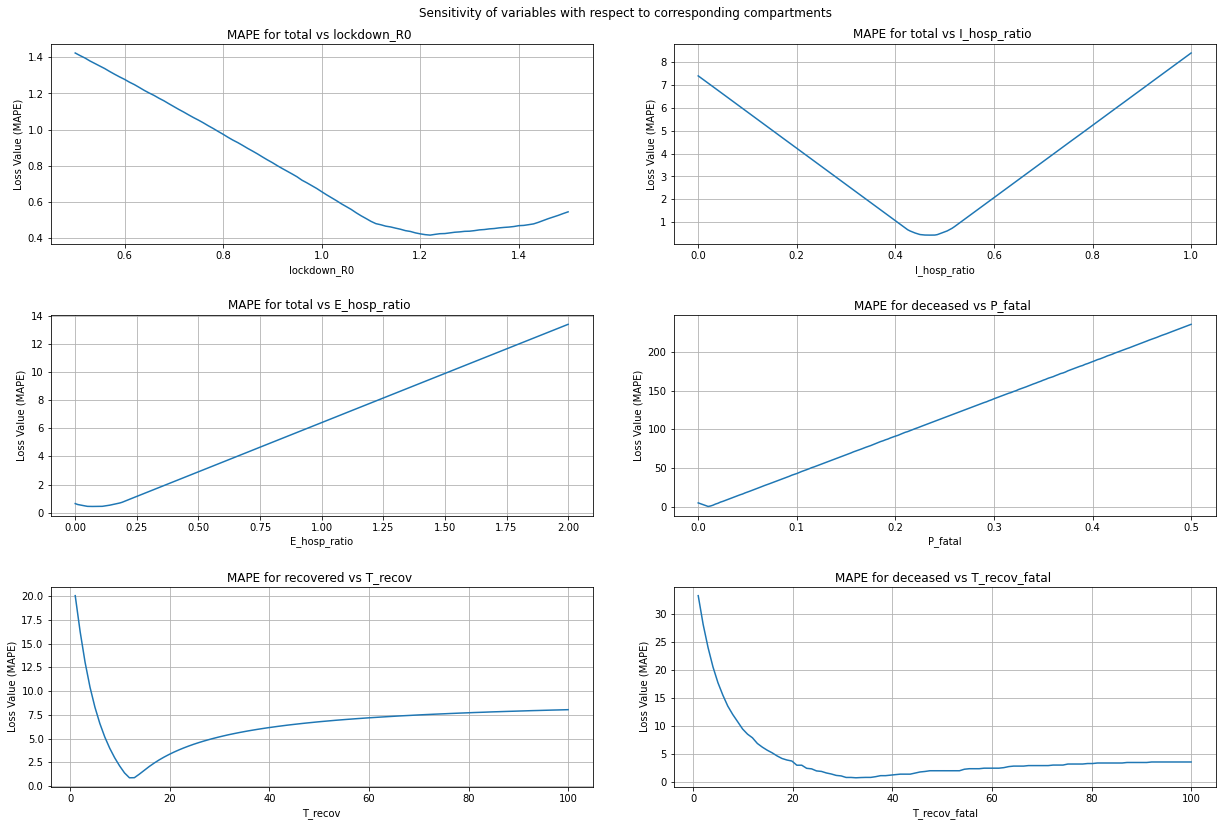

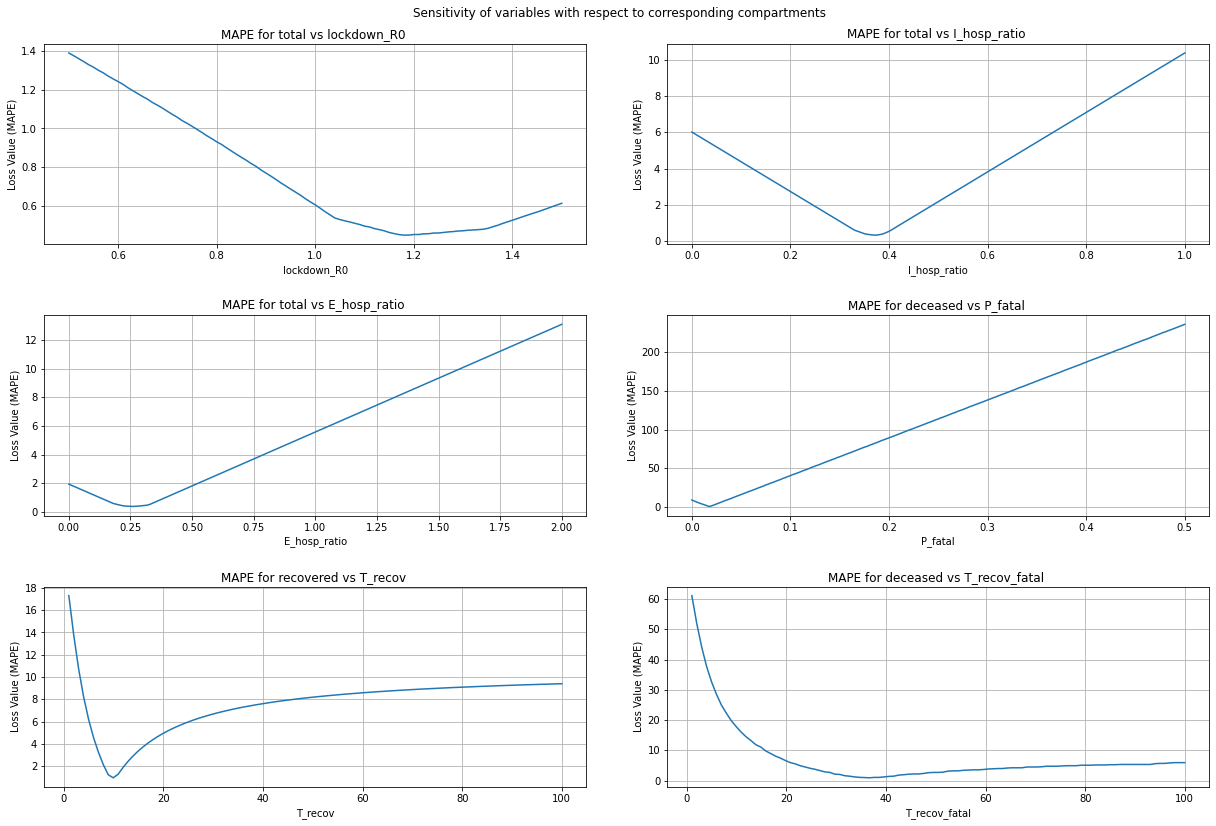

In [11]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [12]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


[         date        S     E     I  R_recov  R_fatal      C    D  active  \
0  2020-09-25  1380675   763  1269     3630       69  13488  103    3699   
1  2020-09-26  1380280   968  1100     3636       74  13834  105    3710   
2  2020-09-27  1379928  1095  1006     3605       77  14178  107    3682   
3  2020-09-28  1379599  1177   955     3557       81  14518  110    3638   
4  2020-09-29  1379284  1231   930     3503       84  14854  112    3587   
5  2020-09-30  1378973  1270   920     3449       86  15184  115    3535   
6  2020-10-01  1378665  1299   919     3398       89  15509  117    3487   
7  2020-10-02  1378356  1323   923     3352       92  15830  120    3444   
8  2020-10-03  1378045  1345   930     3313       94  16146  123    3407   
9  2020-10-04  1377732  1364   940     3279       97  16459  126    3376   
10 2020-10-05  1377415  1383   950     3251       99  16770  128    3350   
11 2020-10-06  1377095  1401   961     3229      102  17077  131    3331   
12 2020-10-

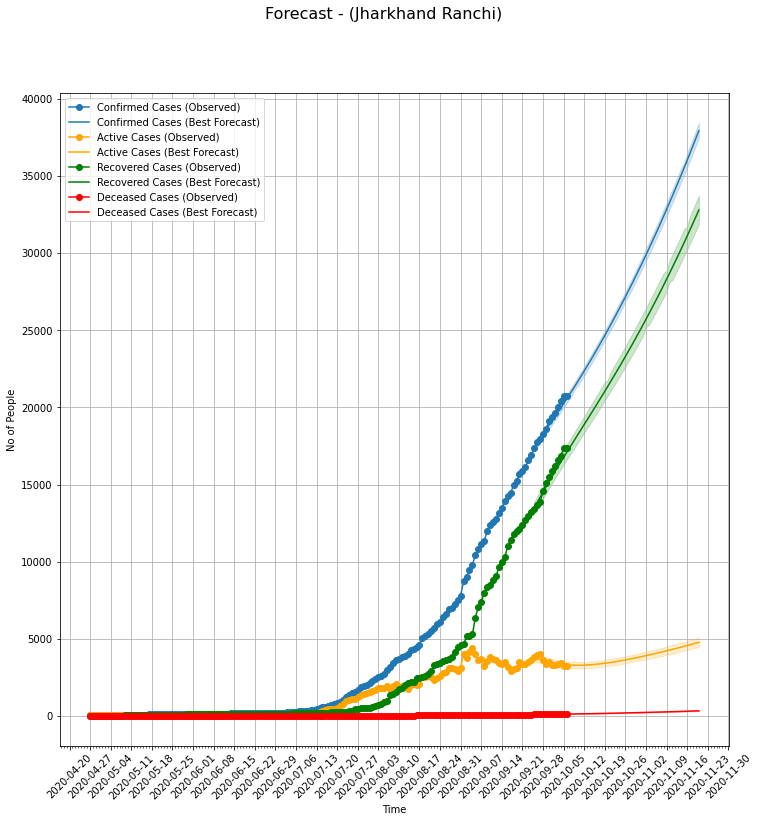

In [13]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

In [14]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

6it [00:00, 59.77it/s]getting forecasts ..
1000it [00:11, 86.07it/s]


In [15]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

5it [00:00, 47.05it/s]getting forecasts ..
1000it [00:11, 90.56it/s]


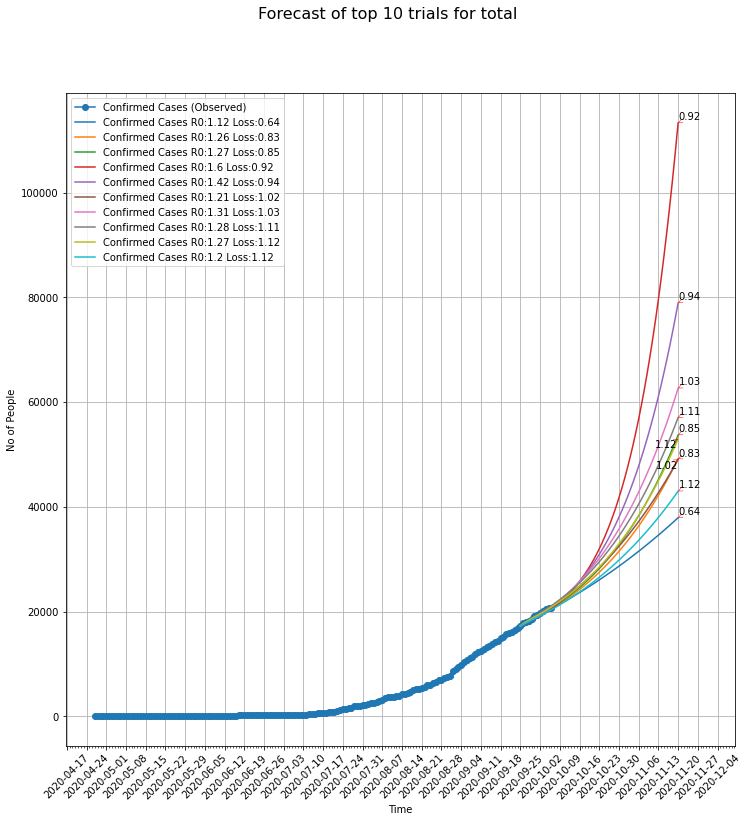

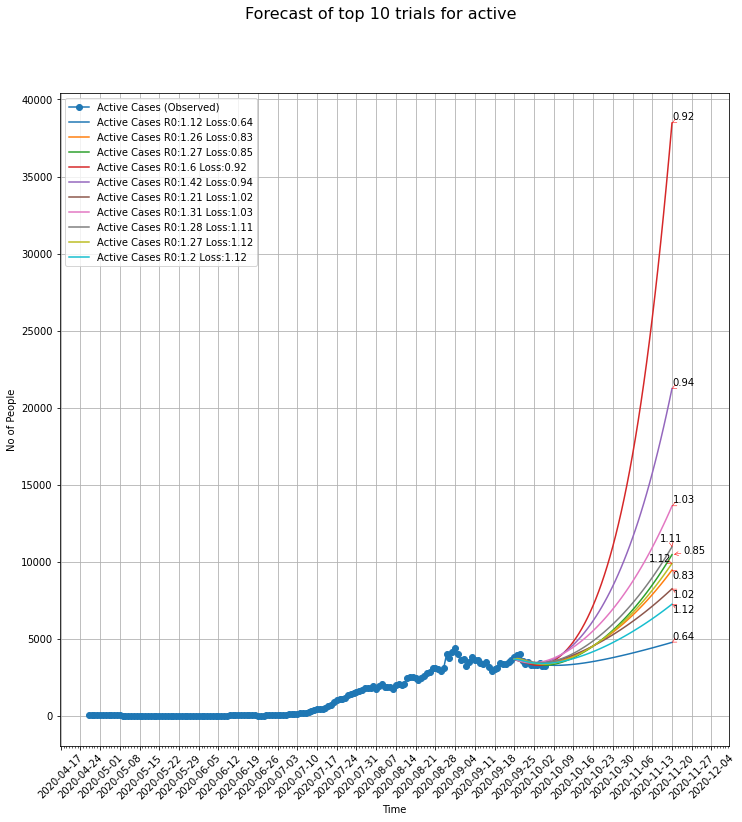

In [16]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [17]:
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [18]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:52&lt;00:00,  1.89trial/s, best loss: 5.538686443004514]


In [19]:
uncertainty.beta_loss

{&#39;active&#39;: 8.354182697421559,
 &#39;recovered&#39;: 4.091693382270798,
 &#39;deceased&#39;: 7.687513016057572,
 &#39;total&#39;: 2.021356676268129}

In [20]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [21]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

2       14178       107  17967  
3       14518       110  18266  
4       14854       112  18553  
5       15184       115  18834  
6       15509       117  19113  
7       15830       120  19394  
8       16146       123  19676  
9       16459       126  19961  
10      16770       128  20248  
11      17077       131  20539  
12      17383       135  20834  
13      17688       138  21133  
14      17992       141  21434  
15      18295       144  21739  
16      18598       147  22048  
17      18901       151  22361  
18      19204       154  22677  
19      19509       158  22998  
20      19814       162  23323  
21      20121       165  23651  
22      20430       169  23984  
23      20741       173  24321  
24      21053       177  24662  
25      21368       181  25006  
26      21685       185  25356  
27      22004       189  25708  
28      22326       193  26066  
29      22651       198  26428  
30      22978       202  26794  
31      23309       206  27164  
32      23

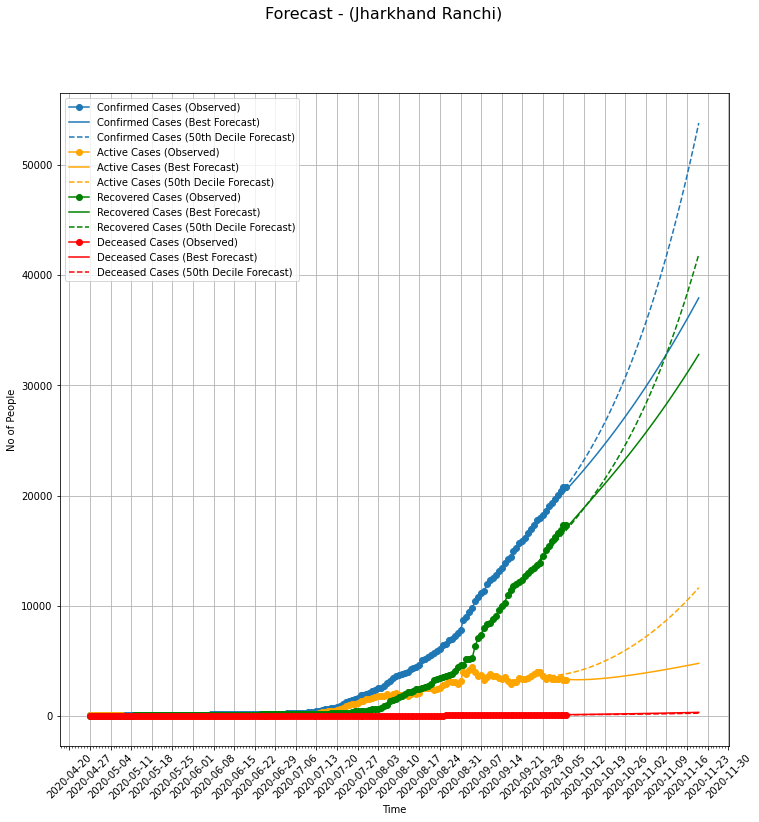

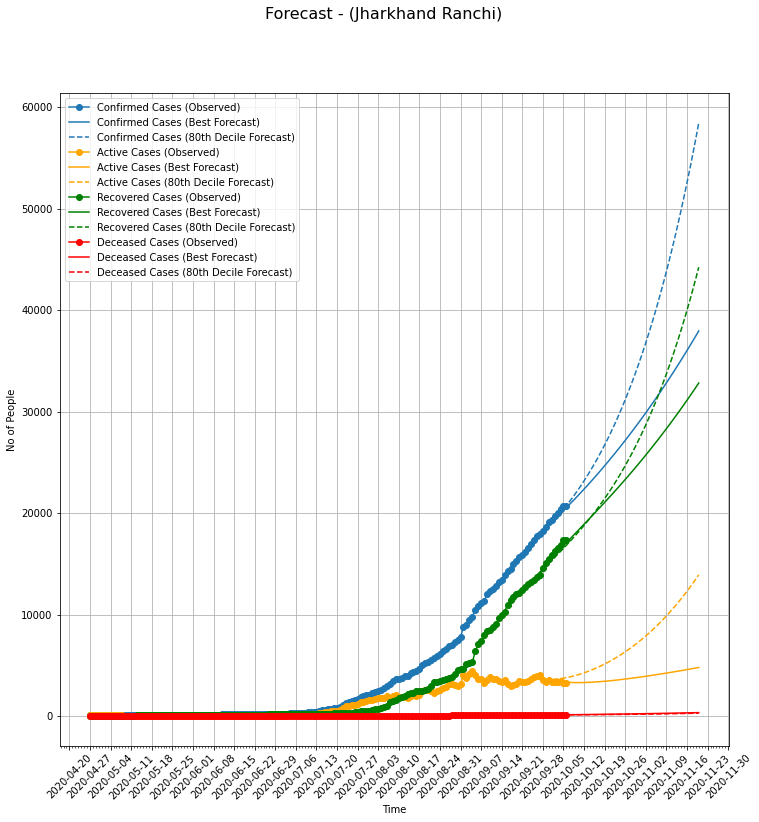

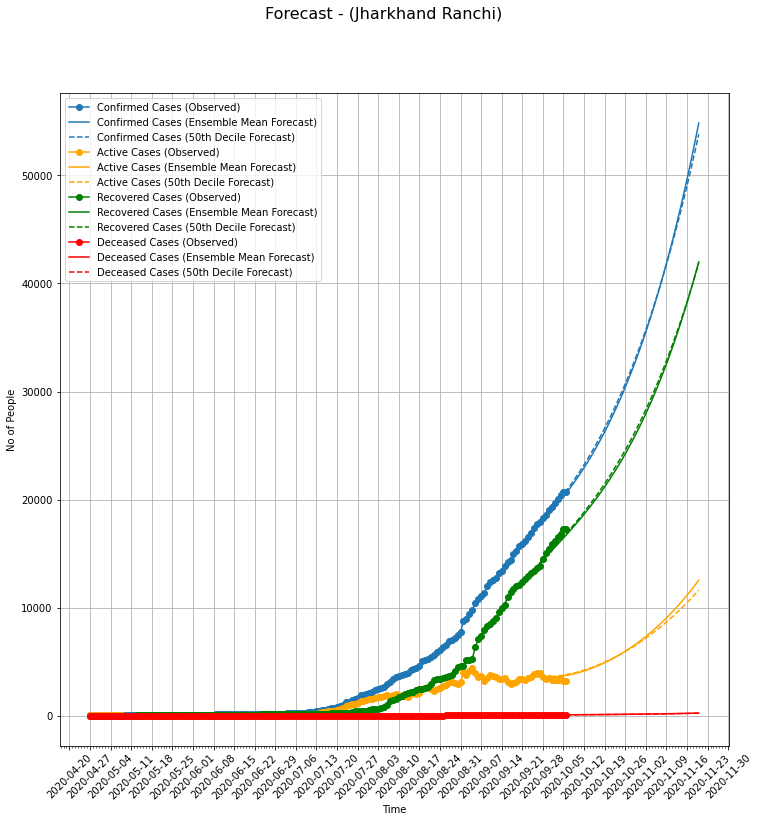

In [22]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

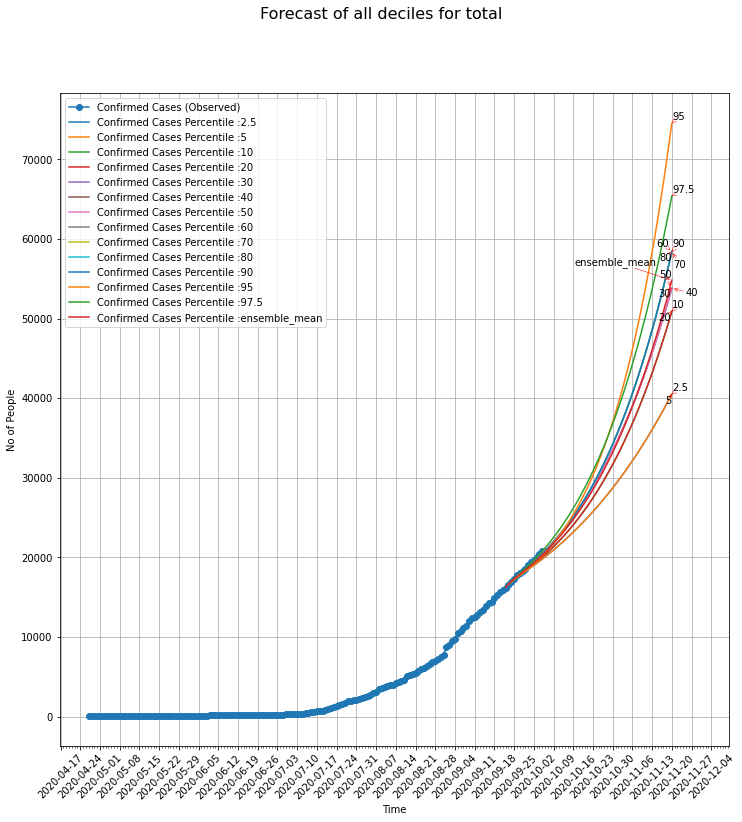

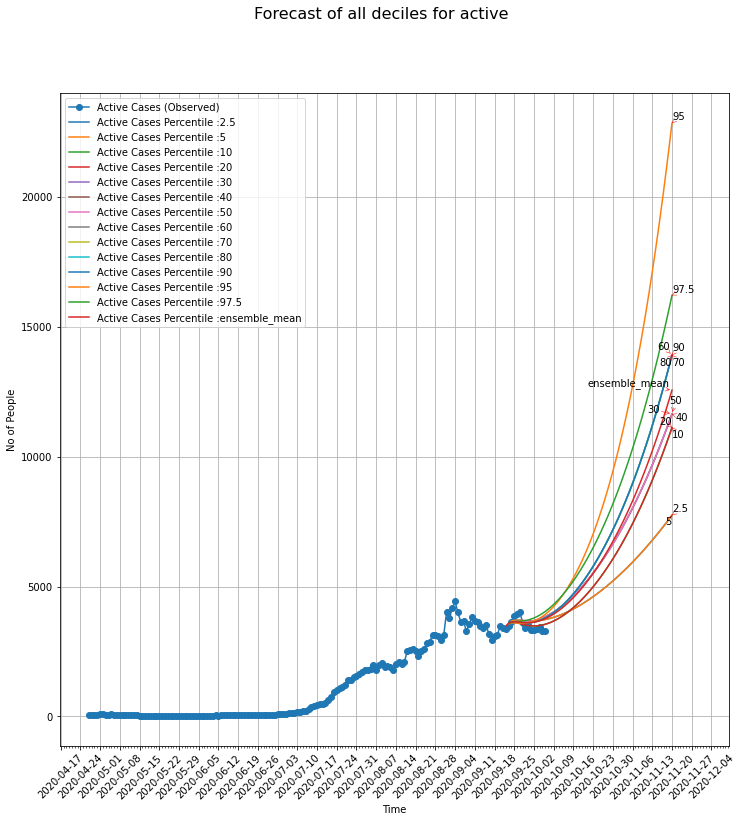

In [23]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## Create Report

In [24]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [25]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [26]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [27]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Experiments

In [28]:
predictions_dict['m1'].keys()

dict_keys([&#39;plots&#39;, &#39;best_params&#39;, &#39;default_params&#39;, &#39;variable_param_ranges&#39;, &#39;optimiser&#39;, &#39;df_prediction&#39;, &#39;df_district&#39;, &#39;df_train&#39;, &#39;df_val&#39;, &#39;df_loss&#39;, &#39;trials&#39;, &#39;data_last_date&#39;, &#39;df_district_unsmoothed&#39;, &#39;run_params&#39;, &#39;trials_processed&#39;])

In [29]:
predictions_dict['m2'].keys()

dict_keys([&#39;plots&#39;, &#39;best_params&#39;, &#39;default_params&#39;, &#39;variable_param_ranges&#39;, &#39;optimiser&#39;, &#39;df_prediction&#39;, &#39;df_district&#39;, &#39;df_train&#39;, &#39;df_val&#39;, &#39;df_loss&#39;, &#39;trials&#39;, &#39;data_last_date&#39;, &#39;df_district_unsmoothed&#39;, &#39;run_params&#39;, &#39;forecasts&#39;, &#39;trials_processed&#39;, &#39;beta&#39;, &#39;beta_loss&#39;, &#39;deciles&#39;])

## R0 Multipliers

In [41]:
r0_mul_params= predictions_dict['m2']['deciles'][80]['params']

{&#39;E_hosp_ratio&#39;: 0.08407157540970184,
 &#39;I_hosp_ratio&#39;: 0.4680510881951535,
 &#39;P_fatal&#39;: 0.009861537063919198,
 &#39;T_inc&#39;: 4.746619148816514,
 &#39;T_inf&#39;: 3.70089349783674,
 &#39;T_recov&#39;: 12.108955966194223,
 &#39;T_recov_fatal&#39;: 35.990952698348515,
 &#39;lockdown_R0&#39;: 1.329728273643411}

In [31]:
predictions_mul_dict = predict_r0_multipliers(predictions_dict, r0_mul_params, 45)

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


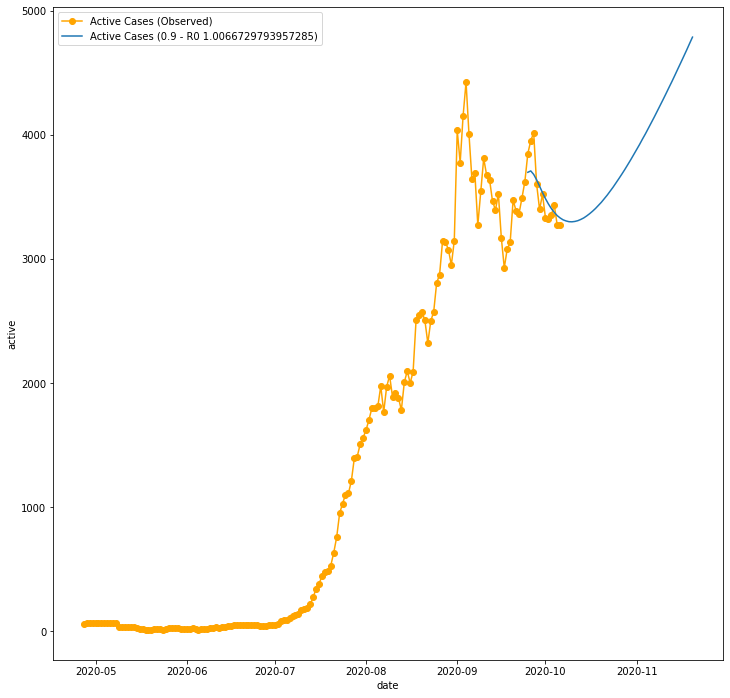

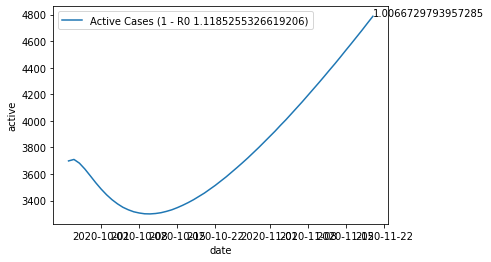

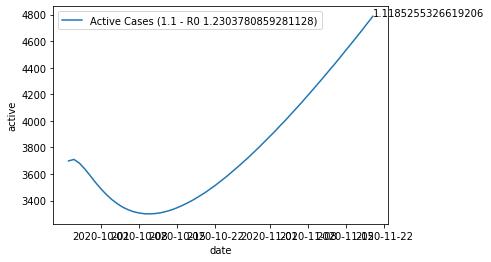

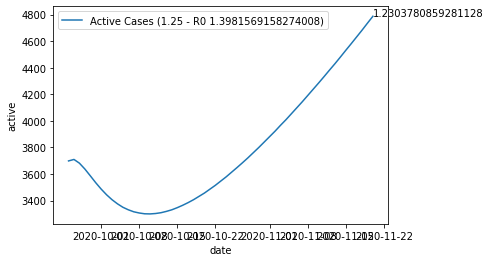

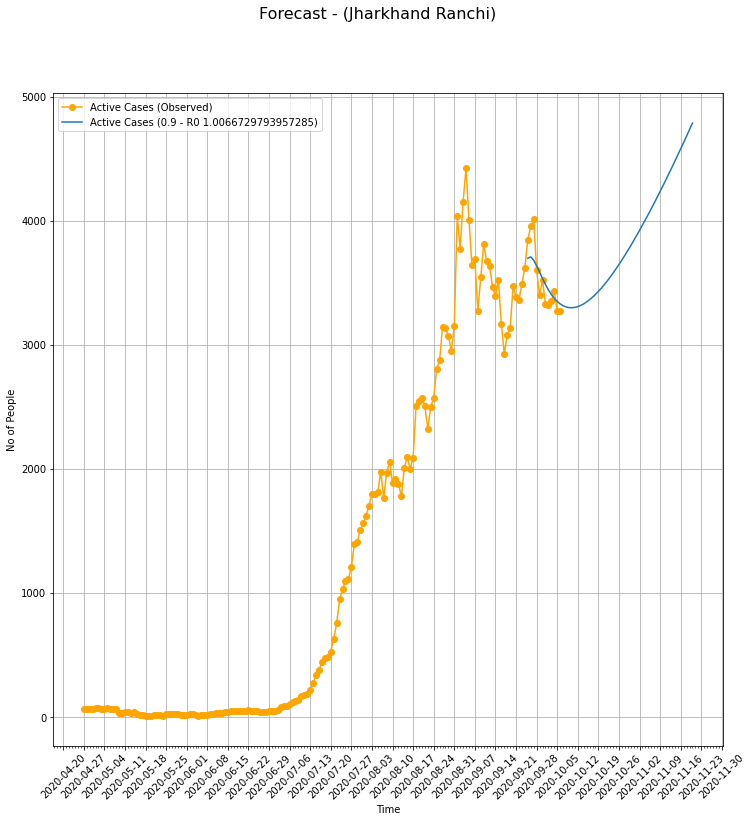

ValueError: Image size of 246998513x1041142 pixels is too large. It must be less than 2^16 in each direction.

In [32]:
plot_r0_multipliers(predictions_dict, None, predictions_mul_dict, None, 'Jharkhand', 'Ranchi')

In [44]:
predictions_mul_dict

20-09-29  1379054   1278   1048     3504       66  14935  111    3570   
  5  2020-09-30  1378639   1394   1058     3441       68  15283  113    3509   
  6  2020-10-01  1378216   1495   1085     3390       71  15624  115    3461   
  7  2020-10-02  1377780   1587   1125     3353       73  15962  118    3426   
  8  2020-10-03  1377326   1676   1173     3330       75  16296  120    3405   
  9  2020-10-04  1376853   1766   1227     3323       78  16629  122    3401   
  10 2020-10-05  1376357   1857   1285     3331       80  16962  125    3411   
  11 2020-10-06  1375838   1951   1347     3354       83  17296  128    3437   
  12 2020-10-07  1375294   2049   1413     3391       86  17633  130    3477   
  13 2020-10-08  1374723   2151   1483     3442       89  17975  133    3531   
  14 2020-10-09  1374124   2258   1556     3507       92  18323  136    3599   
  15 2020-10-10  1373496   2370   1633     3585       96  18678  139    3681   
  16 2020-10-11  1372838   2487   1714     3676